# projx 0.2.8 - Graph transformations in Python

projx provides two ways to interact with graphs: 
- A DSL based on Neo4j Cypher for executing graph transformations using a simple API. 
- A programmatic api that consumes JSON ETL configuration objects and executes graph transformations. Based on orientdb-etl.  

Currently only supports networkx.Graph using the nxetl module. The projx namespace also includes the core module functions for operating on networkx graphs: reset_index, match, traverse, project, transfer, combine, build_sugraph.

In [1]:
%matplotlib inline

In [2]:
import json
import networkx as nx
import projx as px
import matplotlib.pyplot as plt

Install py2neo to use Neo4j module.
Install py2neo to use Neo4j module.


In [3]:
plt.rcParams['figure.figsize'] = 14, 7

### This is the starting state of the graph.

/home/mn/.virtualenvs/projx/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


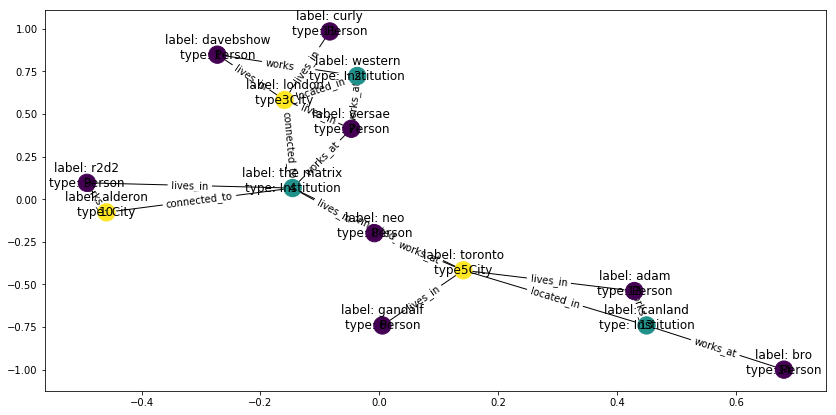

In [4]:
g = nx.read_yaml('example.yaml')

px.draw_simple_graph(g, label_attrs=['label', 'type'], edge_label_attr='type')

### API

In [5]:
# Make a "projection" with a networkx.Graph
projection = px.Projection(g)
# Execute a statement like MATCH.

### MATCH. The ProjX DSL is based on Neo4j's Cypher.

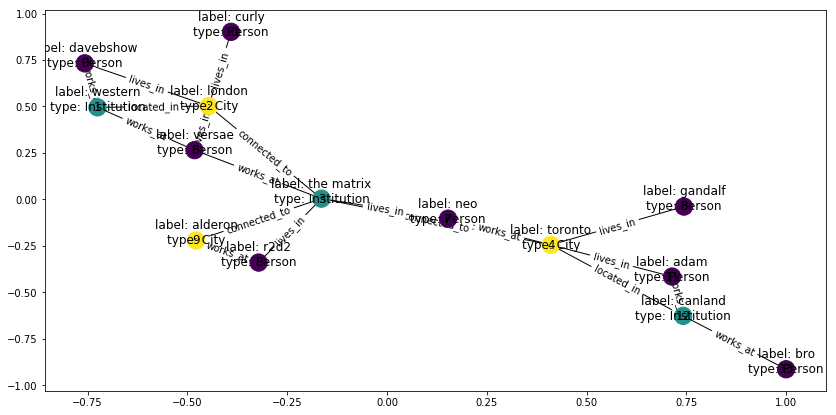

In [6]:
# This just matches the whole graph.
subgraph = projection.execute("MATCH (n)-(m)") # Just like Cypher
px.draw_simple_graph(subgraph, label_attrs=['label', 'type'], edge_label_attr='type')

### PROJECT. Match a subgraph and project across node type.

{'label': 'western', 'weight': 1.5}
{'label': 'london', 'weight': 0.5}
{'label': 'toronto', 'weight': 0.5}
{'label': 'toronto', 'weight': 0.5}
{'label': 'london', 'weight': 0.5}
{'label': 'the matrix', 'weight': 0.5}
{'label': 'the matrix', 'weight': 0.5}
{'label': 'the matrix', 'weight': 0.5}
{'label': 'toronto', 'weight': 0.5}
{'label': 'canland', 'weight': 1.0}


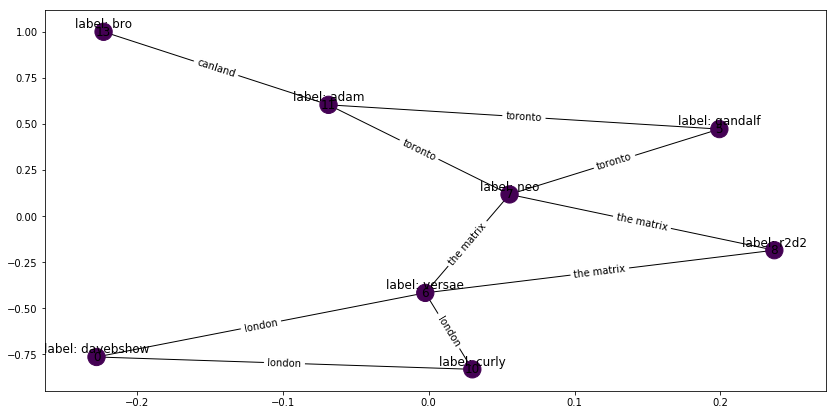

In [7]:
# We didn't commit the cursor, so we can use it again like it was rolled back.
# Here we use a match pattern and the transformation ver PROJECT to project a social network.
# To calculate edgeweight, we need to specify a method, and which node types to calculate the 
# measure over. The SET param NEW implicity refers to the new edge created by the projection.
subgraph = projection.execute("""
    MATCH   (p1:Person)-(wild)-(p2:Person)
    PROJECT (p1)-(p2)
    METHOD NEWMAN Institution, City
    SET     label = wild.label
    DELETE  wild
""")
# Edge label here is wildcard match name.
px.draw_simple_graph(subgraph, edge_label_attr='label')

### ETL API - Based on orientdb-etl

In [8]:
project_etl = {
    "extractor": {
        "networkx": {
            "type": "subgraph", 
            "node_type_attr": "type",
            "edge_type_attr": "type",
            "traversal": [
                {"node": { "alias": "p1", "type": "Person"}}, 
                {"edge": {}}, 
                {"node": {"alias": "wild"}}, 
                {"edge": {}}, 
                {"node": {"alias": "p2", "type": "Person"}}
            ]
        }
    }, 
    "transformers": [
        {
            "project": {
                "pattern": [
                    {"node": {"alias": "p1"}}, 
                    {"edge": {}}, 
                    {"node": {"alias": "p2"}}
                ], 
                "set": [
                    {"key": "name", "value_lookup": "wild.label"}
                ], 
                "method": {
                    "newman": {
                        "args": ["Institution", "City"]
                    }
                }, 
                "delete": {
                    "alias": ["wild"]
                }
            }
        }
    ], 
    "loader": {
        "nx2nx": {}
    }
}

### Executing the ETL JSON is pretty easy:

{'name': 'western', 'weight': 1.5}
{'name': 'london', 'weight': 0.5}
{'name': 'toronto', 'weight': 0.5}
{'name': 'toronto', 'weight': 0.5}
{'name': 'london', 'weight': 0.5}
{'name': 'the matrix', 'weight': 0.5}
{'name': 'the matrix', 'weight': 0.5}
{'name': 'the matrix', 'weight': 0.5}
{'name': 'toronto', 'weight': 0.5}
{'name': 'canland', 'weight': 1.0}


EdgeDataView([(0, 6, {'name': {'western': 2, 'london': 2}, 'weight': 1.5}), (0, 10, {'name': {'london': 2}, 'weight': 0.5}), (6, 10, {'name': {'london': 2}, 'weight': 0.5}), (6, 7, {'name': {'the matrix': 2}, 'weight': 0.5}), (6, 8, {'name': {'the matrix': 2}, 'weight': 0.5}), (5, 7, {'name': {'toronto': 2}, 'weight': 0.5}), (5, 11, {'name': {'toronto': 2}, 'weight': 0.5}), (7, 8, {'name': {'the matrix': 2}, 'weight': 0.5}), (7, 11, {'name': {'toronto': 2}, 'weight': 0.5}), (11, 13, {'name': {'canland': 2}, 'weight': 1.0})])

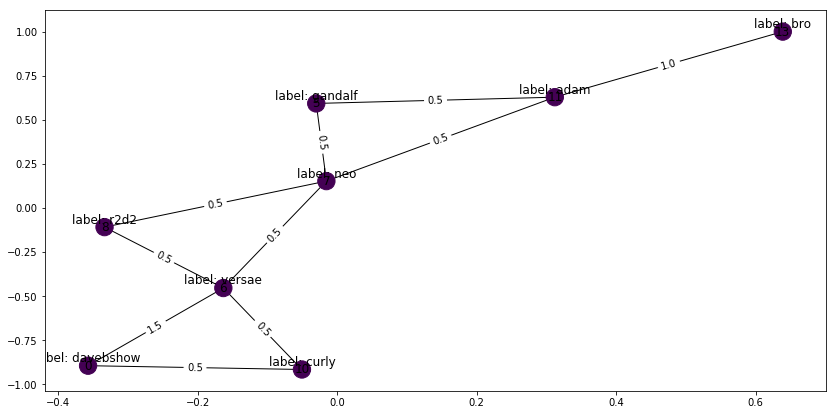

In [9]:
subgraph = px.execute_etl(project_etl, g)
px.draw_simple_graph(subgraph)
subgraph.edges(data=True)

### It's actually all ETL, the DSL parser produces ETL JSON.

In [10]:
import pprint as pp

pp.pprint(px.parse_query(("""
    MATCH   (p1:Person)-(wild)-(p2:Person)
    PROJECT (p1)-(p2)
    METHOD JACCARD Institution, City
    SET     name = wild.label
    DELETE  wild
""")))

{'extractor': {'networkx': {'traversal': [{'node': {'alias': 'p1',
                                                    'type': 'Person'}},
                                          {'edge': {}},
                                          {'node': {'alias': 'wild'}},
                                          {'edge': {}},
                                          {'node': {'alias': 'p2',
                                                    'type': 'Person'}}],
                            'type': 'subgraph'}},
 'loader': {'nx2nx': {}},
 'transformers': <map object at 0x7fd99c3e8f98>}


### TRANSFER. Transfer edges and attributes from one node type to another. 

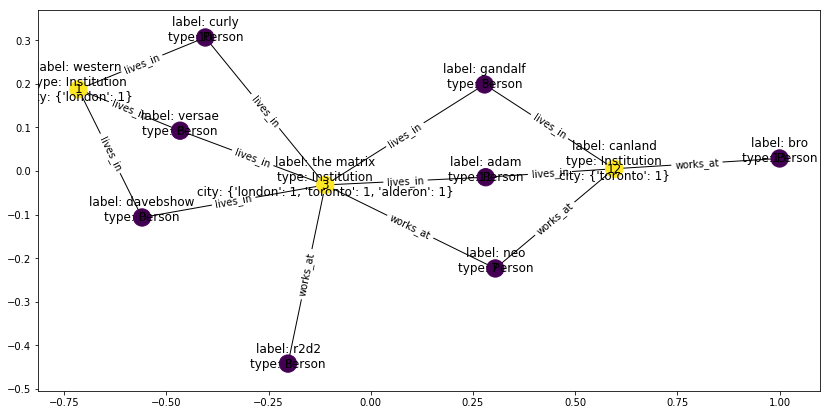

In [11]:
# Transfer the attributes and edges from all the institutions neighboring cities nodes.
# Here we pass the GRAPH object to the verb MATCH. This allows us to perform the 
# transfomation accross the entire graph, instead of matching a subgraph and then performing the 
# transformation. NOTE - TRANSFER is directional, unlike PROJECT.

subgraph = projection.execute("""
    MATCH GRAPH (c:City)-(i:Institution)
    TRANSFER    (c)-(i)
    METHOD      EDGES Person
    SET         city = c.label
    DELETE      c
""")
px.draw_simple_graph(subgraph, label_attrs=['label', 'city', 'type'], edge_label_attr='type')

### Equivalent ETL JSON for Transfer

In [12]:
transfer_etl = {
    "extractor": {
        "networkx": {
            "type": "graph", 
            "node_type_attr": "type",
            "edge_type_attr": "type",
            "traversal": [
                {
                    "node": {
                        "alias": "c", 
                        "type": "City"
                    }
                }, 
                {
                    "edge": {}
                }, 
                {
                    "node": {
                        "alias": "i", 
                        "type": "Institution"
                    }
                }
            ]
        }
    }, 
    "transformers": [
        {
            "transfer": {
                "pattern": [
                    {"node": {"alias": "c"}}, 
                    {"edge": {}}, 
                    {"node": {"alias": "i"}}
                ], 
                "set": [
                    {"key": "city", "value_lookup": "c.label"}
                ], 
                "method": {
                    "edges": {
                        "args": ["Person"]
                    }
                }, 
                "delete": {
                    "alias": ["c"]
                }
            }
        }
    ], 
    "loader": {
        "nx2nx": {}
    }
}

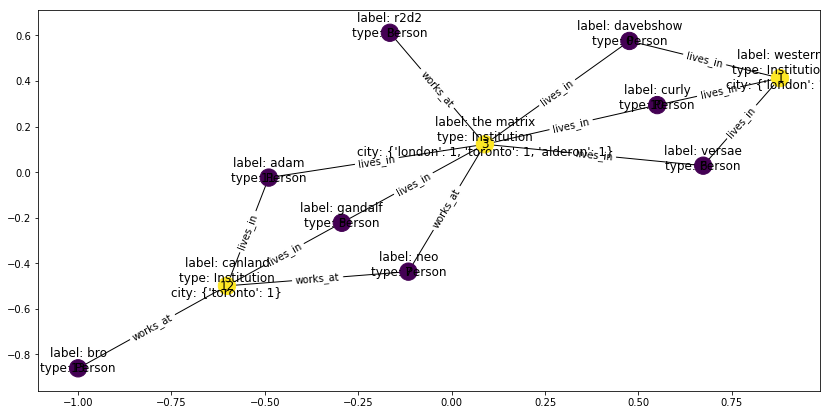

In [13]:
subgraph = px.execute_etl(transfer_etl, g)
px.draw_simple_graph(subgraph, label_attrs=['label', 'city', 'type'], edge_label_attr='type')

### COMBINE. Combine two node types creating a new node of a new type.

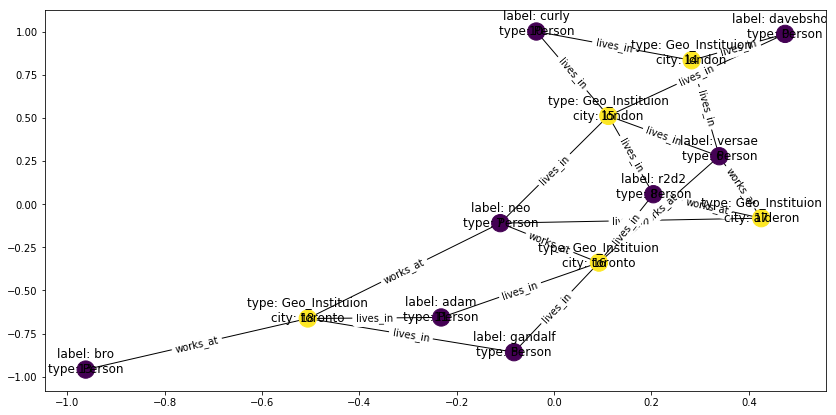

In [14]:
# Here NEW refers to the newly created node.
subgraph = projection.execute("""
    MATCH GRAPH (i:Institution)-(c:City)
    COMBINE     (i)-(c)
    SET         type = "Geo_Instituion", name = i.label, city = c.label
    DELETE      i, c
""")
px.draw_simple_graph(subgraph, label_attrs=["label", "type", "city"], edge_label_attr='type')

### Equivalent ETL:

In [15]:
pp.pprint(px.parse_query("""
    MATCH GRAPH (i:Institution)-(c:City)
    COMBINE     (i)-(c) 
    SET         type = "Geo_Instituion", name = i.label, city = c.label
    DELETE      i, c
"""))

{'extractor': {'networkx': {'traversal': [{'node': {'alias': 'i',
                                                    'type': 'Institution'}},
                                          {'edge': {}},
                                          {'node': {'alias': 'c',
                                                    'type': 'City'}}],
                            'type': 'graph'}},
 'loader': {'nx2nx': {}},
 'transformers': <map object at 0x7fd99c4f3be0>}


### MATCH (SUBGRAPH) vs. MATCH GRAPH. MATCH SUBGRAPH is the default behaviour of MATCH.

{}
{}
{}
{}
{}


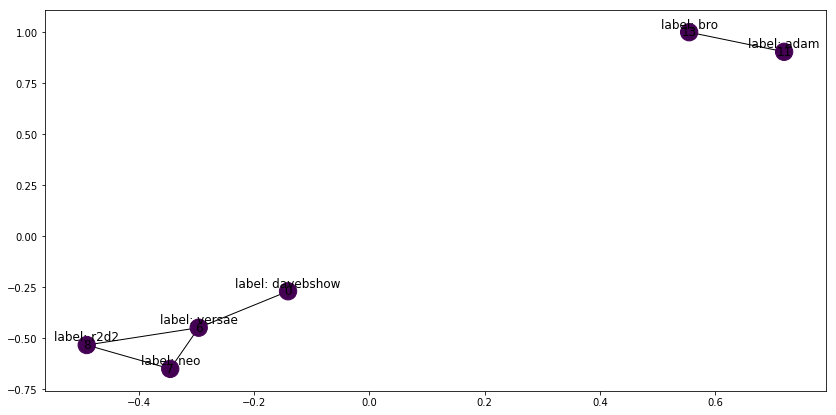

In [16]:
# Until now, we have been matching just subgraphs, like this only we didn't explicity 
# specify that we were only matching a subgraph.
subgraph = projection.execute("""
    MATCH SUBGRAPH (p1:Person)-(i:Institution)-(p2:Person)
    PROJECT        (p1)-(p2)
    DELETE         i
""")
px.draw_simple_graph(subgraph)

{}
{}
{}
{}
{}


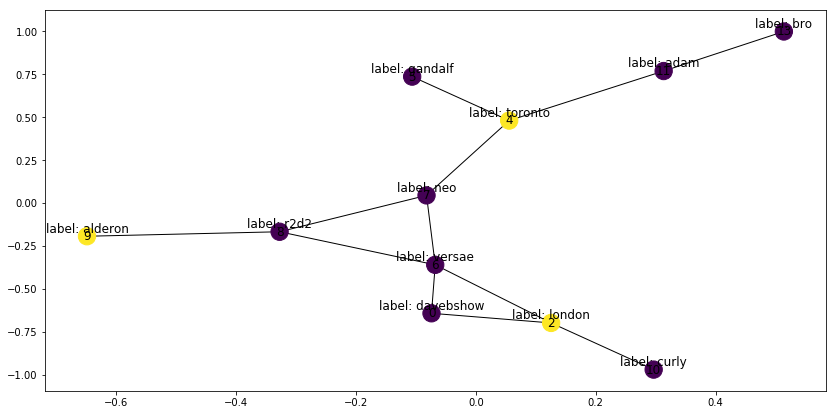

In [17]:
# We can use MATCH GRAPH to match patterns across the whole graph.
# Notice how this retains the cities as well, and also affects the edge weight calculations.
# This is more often used with TRANSFER and COMBINE (see previous examples).
subgraph = projection.execute("""
    MATCH GRAPH (p1:Person)-(i:Institution)-(p2:Person)
    PROJECT     (p1)-(p2)
    DELETE      i
""")
px.draw_simple_graph(subgraph)

### Edge types can be used as well for matching criteria.

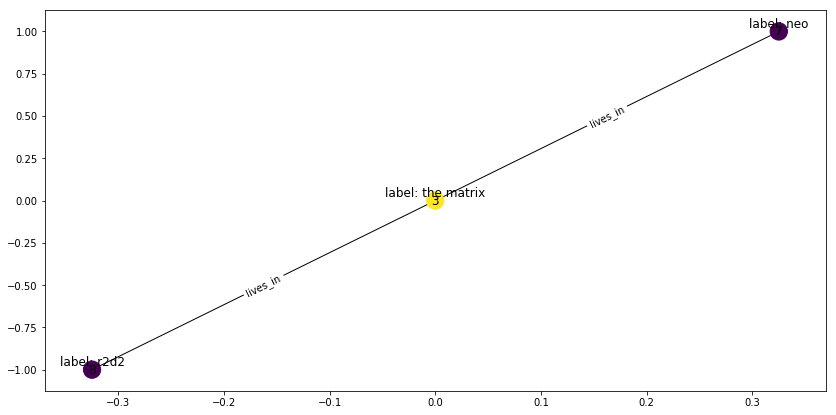

In [18]:
subgraph = projection.execute("""
    MATCH (p1:Person)-[e:lives_in]-(i:Institution)
""")
px.draw_simple_graph(subgraph, edge_label_attr='type')

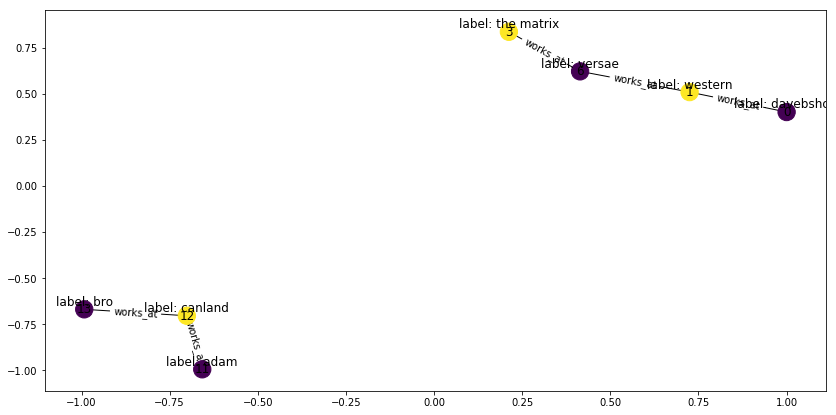

In [19]:
subgraph = projection.execute("""
    MATCH (p1:Person)-[e:works_at]-(i:Institution)
""")
px.draw_simple_graph(subgraph, edge_label_attr='type')

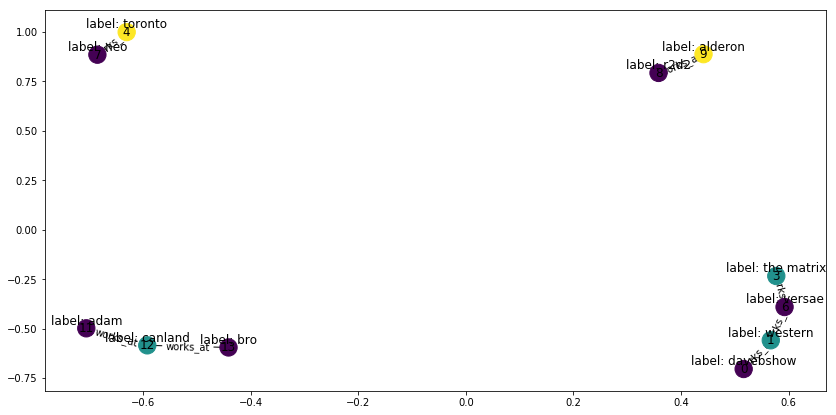

In [20]:
subgraph = projection.execute("""
    MATCH (p1:Person)-[e:works_at]-(wild)
""")
px.draw_simple_graph(subgraph, edge_label_attr='type')

### Perform multiple transformations in a pipeline (example is a bit contrived).

In [21]:
multi_transform_etl = {
    "extractor": {
        "networkx": {
            "traversal": [
                {"node": {"alias": "p1", "type": "Person"}},
                {"edge": {}},
                {"node": {"alias": "i", "type": "Institution"}},
                {"edge": {}},
                {"node": {"alias": "c", "type": "City"}}
            ],
            "type": "subgraph"
        }
    },
    "loader": {
        "nx2nx": {}
    },
    "transformers": [
        {
            "transfer": {
                "delete": {
                    "alias": []
                },
                "method": {
                    "attrs": {
                        "args": []
                    }
                },
                "pattern": [
                    {"node": {"alias": "i"}},
                    {"edge": {}},
                    {"node": {"alias": "c"}}
                ],
                "set": [
                    {"key": "inst", "value_lookup": "i.label"}
                ]
            }
        },
        {
            "project": {
                "delete": {
                    "alias": [
                        "i"
                    ]
                },
                "method": {
                    "jaccard": {
                        "args": [
                            "Institution"
                        ]
                    }
                },
                "pattern": [
                    {"node": {"alias": "p1"}},
                    {"edge": {}},
                    {"node": {"alias": "c"}}
                ],
                "set": [{}]
            }
        }
    ]
}
subgraph = px.execute_etl(multi_transform_etl, g)
px.draw_simple_graph(subgraph, label_attrs=["label", "inst", "type"])

{0: '', 'weight': 0.5}


TypeError: add_edge() keywords must be strings